<h1>Top 10 Classification - Random Forest</h1>
<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/ocr')

Mounted at /content/drive


In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from importation import Importation

# Importation des données - preprocessing

In [3]:
imp = Importation('database')
df = imp.get_words().sample(frac=1, random_state=1).reset_index()

df.word_size = df.word_size.astype('float32')
print("Nombre d'enregistrements ", df.shape[0])


df = df[['file','label', 'word_size']]
df.info()
num_classes = 10
words_list = df[(df.word_size==3)|(df.word_size==4)].label.value_counts().head(num_classes)
print("\nTop 10 mots 3 ou 4 lettres : \n")
print(words_list)

df = df[df.label.isin(words_list.index)]
encoder = LabelEncoder()
df["label_encoded"] = encoder.fit_transform(df.label)

df.head(20)

# On redimensionne les images à 128x32
image_width = 128
image_height = 32

img_size = (image_width, image_height)

X = []
Y = []

dim = (image_width, image_height)
for file, label in zip(df["file"],df["label"]):
    image = cv2.resize(cv2.imread(file, cv2.IMREAD_GRAYSCALE),
                  dim, cv2.IMREAD_GRAYSCALE)
    X.append(np.array(image))
    Y.append(label)

# Normalise input data to range [0,1]
X = np.array(X)
X = X.astype('float32')
shape = list(X.shape)
shape.append(1)
X = X.reshape(shape)
X /= 255.0

# Encodage des labels
X = X.reshape([-1, image_width*image_height])
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

Nombre d'enregistrements  96454
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96454 entries, 0 to 96453
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file       96454 non-null  object 
 1   label      96454 non-null  object 
 2   word_size  96454 non-null  float32
dtypes: float32(1), object(2)
memory usage: 1.8+ MB

Top 10 mots 3 ou 4 lettres : 

the     4986
and     2110
was      970
that     968
for      718
had      670
with     645
his      597
The      548
not      412
Name: label, dtype: int64


<h3>Random Forest</h3>



In [4]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [5]:
test_pred = clf.predict(X_test)

print(accuracy_score(y_test, test_pred))
print(classification_report(encoder.inverse_transform(y_test), encoder.inverse_transform(test_pred)))
cnf_matrix = confusion_matrix(y_test, test_pred)

0.8561470215462611
              precision    recall  f1-score   support

         The       1.00      0.48      0.65       140
         and       0.86      0.94      0.90       542
         for       0.91      0.79      0.85       176
         had       0.89      0.65      0.75       170
         his       0.92      0.60      0.72       147
         not       0.93      0.37      0.52       101
        that       0.85      0.82      0.83       224
         the       0.83      0.99      0.90      1248
         was       0.90      0.85      0.87       248
        with       0.85      0.78      0.81       160

    accuracy                           0.86      3156
   macro avg       0.89      0.72      0.78      3156
weighted avg       0.86      0.86      0.85      3156



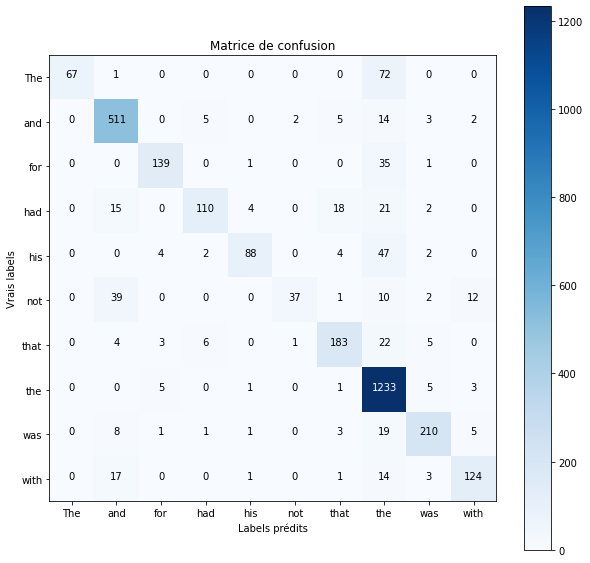

Le mot 'The' a souvent été pris pour le mot 'the'
Le mot 'for' a souvent été pris pour le mot 'the'
Le mot 'had' a souvent été pris pour le mot 'that'
Le mot 'had' a souvent été pris pour le mot 'the'
Le mot 'his' a souvent été pris pour le mot 'the'
Le mot 'not' a souvent été pris pour le mot 'and'
Le mot 'that' a souvent été pris pour le mot 'the'
Le mot 'was' a souvent été pris pour le mot 'the'
Le mot 'with' a souvent été pris pour le mot 'and'


In [8]:
###Afficher une matrice de confusion sous forme de tableau coloré

plt.figure(figsize=(10,10))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(num_classes)
classes = encoder.inverse_transform(tick_marks)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    if(cnf_matrix[i,j] >15 and i!=j):
        print("Le mot '{0}' a souvent été pris pour le mot '{1}'".format(classes[i],classes[j]))